<a href="https://colab.research.google.com/github/dsmgoooner/Football-Prediction/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.utils import resample
from sklearn.preprocessing import scale
from sklearn.model_selection import  train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score,ConfusionMatrixDisplay
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/combined_football_data.csv'

df = pd.read_csv(file_path,)
df.reset_index(drop=True, inplace=True)

df.head()

Mounted at /content/drive


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,E0,11-08-2017,Arsenal,Leicester,4,3,H,2,2,D,...,10,3,9,12,9,4,0,1,0,0
1,E0,12-08-2017,Brighton,Man City,0,2,A,0,0,D,...,2,4,6,9,3,10,0,2,0,0
2,E0,12-08-2017,Chelsea,Burnley,2,3,A,0,3,A,...,6,5,16,11,8,5,3,3,2,0
3,E0,12-08-2017,Crystal Palace,Huddersfield,0,3,A,0,2,A,...,4,6,7,19,12,9,1,3,0,0
4,E0,12-08-2017,Everton,Stoke,1,0,H,1,0,H,...,4,1,13,10,6,7,1,1,0,0


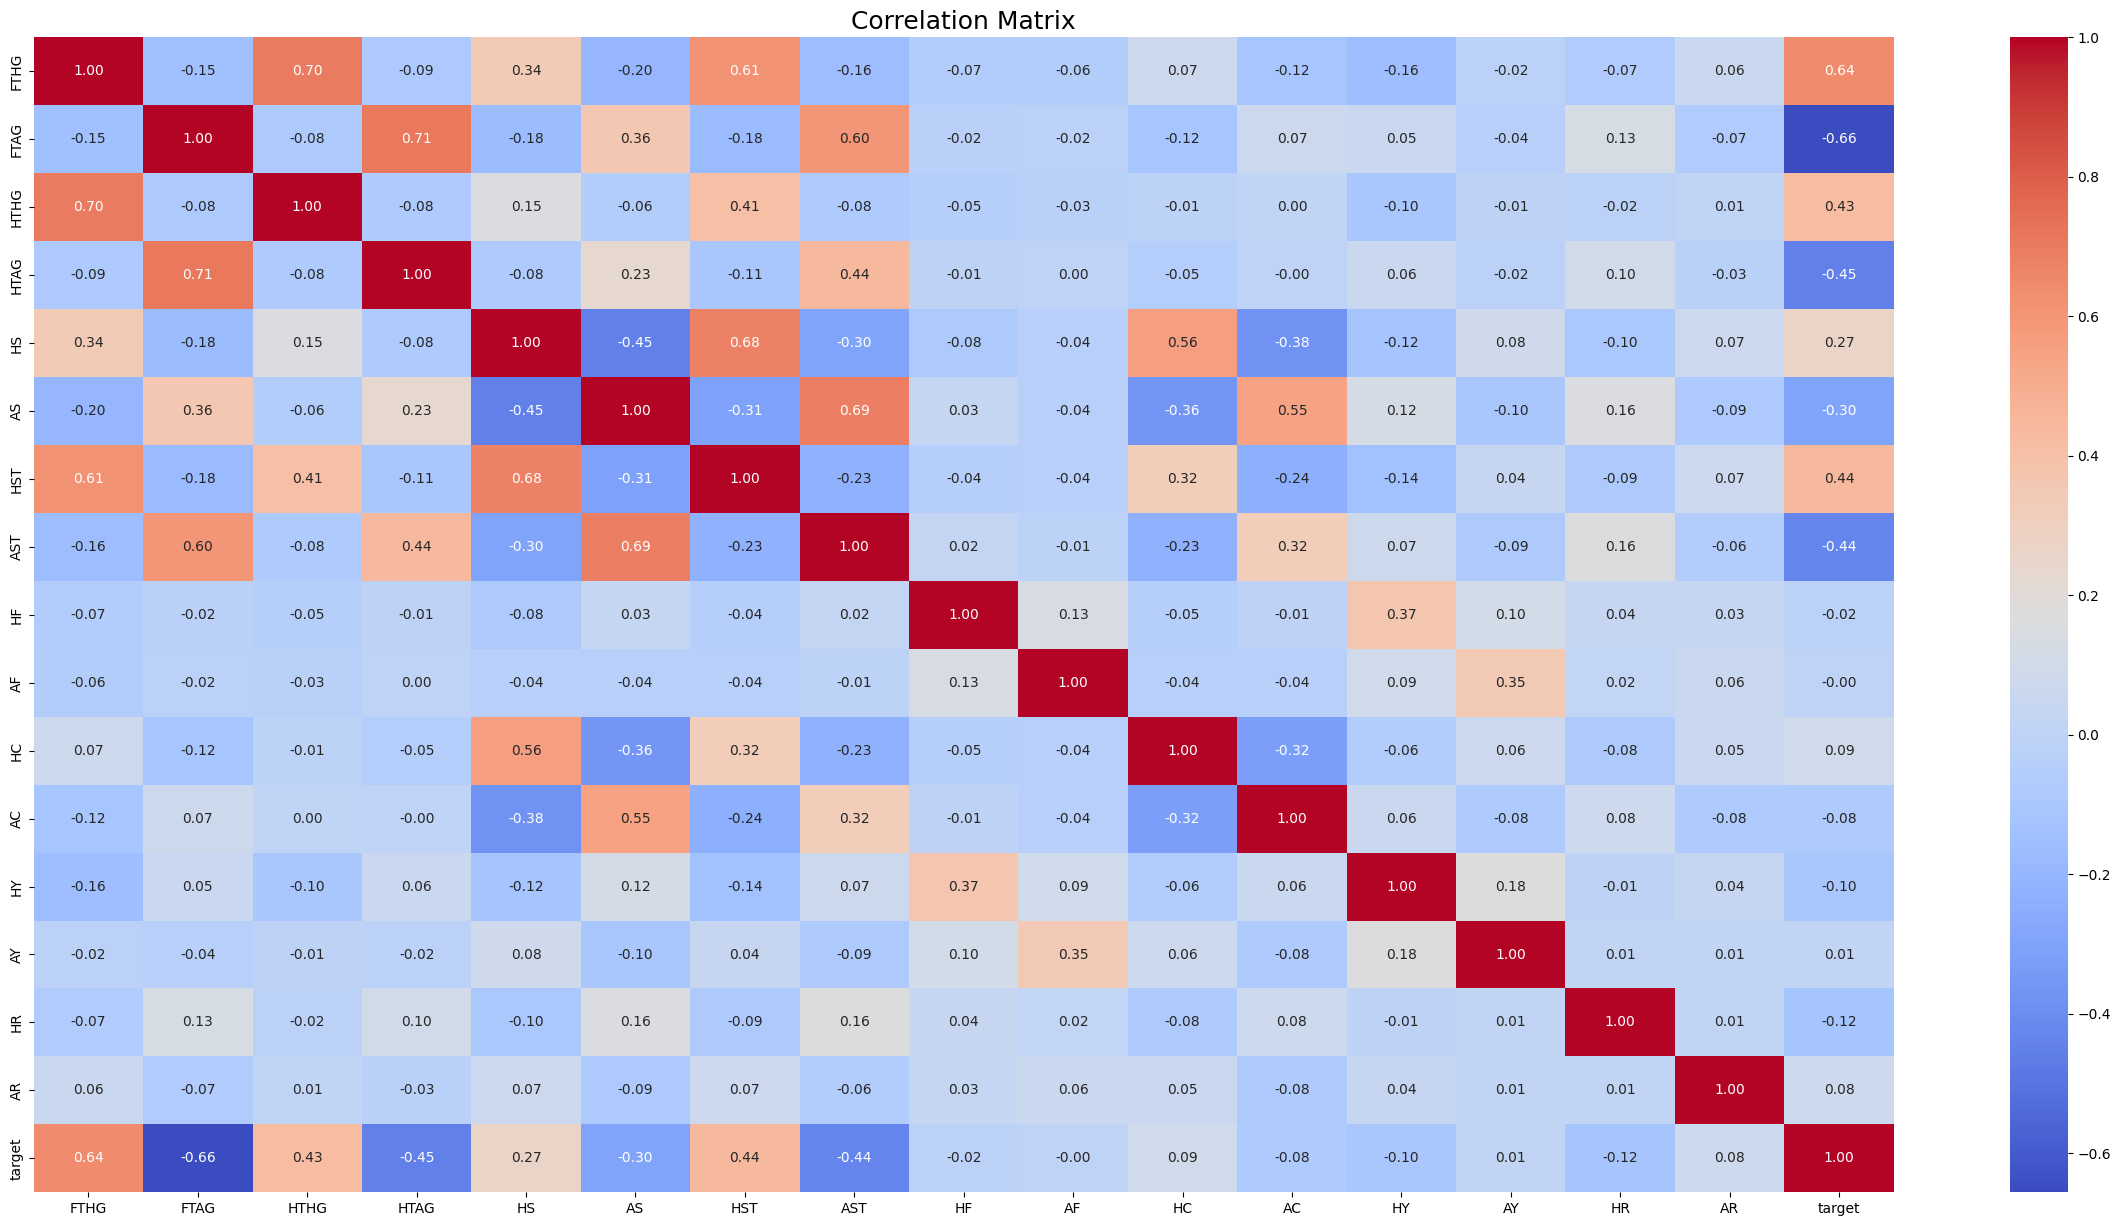

Correlation with target:
target    1.000000
FTHG      0.641745
HST       0.439874
HTHG      0.426170
HS        0.267757
HC        0.094146
AR        0.080303
AY        0.010370
AF       -0.000248
HF       -0.020688
AC       -0.076974
HY       -0.102180
HR       -0.122257
AS       -0.297870
AST      -0.435627
HTAG     -0.451278
FTAG     -0.656267
Name: target, dtype: float64


In [ ]:
# Correlation Matrix

# Setting Target
df['target'] = df['FTR'].map({'H': 2, 'D': 1, 'A': 0})

# Exclude non-numeric columns
numeric_df = df.select_dtypes(include = ['number'])

# Calculate the correlation matrix
corr_matrix = numeric_df.corr()

# Extract the correlation of features with the target variable 'target'
corr_with_target = corr_matrix['target']

# Sort the correlation values in descending order
corr_with_target_sorted = corr_with_target.sort_values(ascending=False)

# Plot yhe correlation matrix heatmap
plt.figure(figsize=(30,15))
sns.heatmap(numeric_df.corr(), annot = True, cmap='coolwarm',fmt=".2f")
sns.set(font_scale = 1.5)
plt.title('Correlation Matrix')
plt.show()

# Display correlation of feature with target variable 'target'
print('Correlation with target:')
print(corr_with_target_sorted)

<ipython-input-5-eb8a5c16dbe5>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = ['Home Wins', 'Away Wins', 'Draws'],


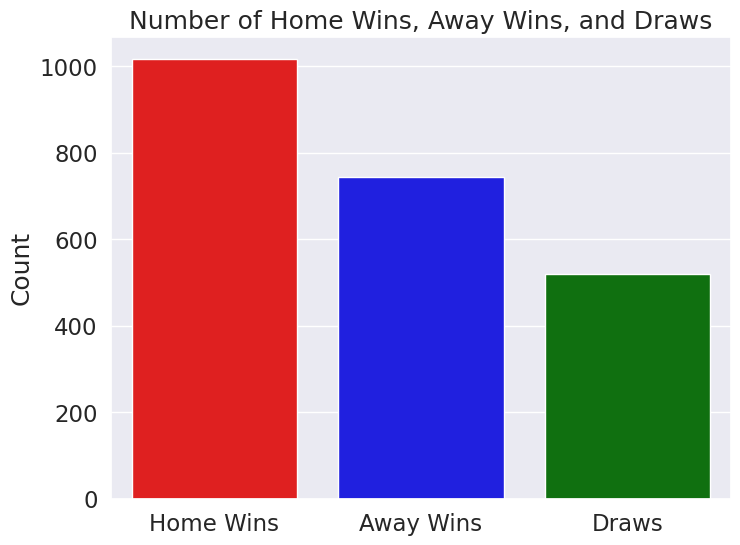

In [ ]:
# Count the number of home wins, away wins and draws
home = df[df['FTR'] == 'H'].shape[0] ## shape[0] used to extract the count of rows
away = df[df['FTR'] == 'A'].shape[0]
draw = df[df['FTR'] == 'D'].shape[0]

# Create a bar plot to visualize the counts
plt.figure(figsize=(8,6))
sns.barplot(x = ['Home Wins', 'Away Wins', 'Draws'],
            y = [home, away, draw],
            palette=['red', 'blue', 'green'])
plt.title('Number of Home Wins, Away Wins, and Draws')
plt.ylabel('Count')
plt.show()

In [ ]:
print('Home Wins:', home)
print('Away Wins:', away)
print('Draw:', draw)

Home Wins: 1017
Away Wins: 743
Draw: 520


In [ ]:
#Identifying Missing Data
df.isnull().sum()

Div         0
Date        0
HomeTeam    0
AwayTeam    0
FTHG        0
FTAG        0
FTR         0
HTHG        0
HTAG        0
HTR         0
HS          0
AS          0
HST         0
AST         0
HF          0
AF          0
HC          0
AC          0
HY          0
AY          0
HR          0
AR          0
target      0
dtype: int64

In [ ]:
#Format Data 1 : One Hot Encoding
df_encoded = pd.get_dummies(df, columns = ['HomeTeam',
                                                      'AwayTeam',
                                                      ])
df_encoded.head()

,Div,Date,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,...,AwayTeam_Nott'm Forest,AwayTeam_Sheffield United,AwayTeam_Southampton,AwayTeam_Stoke,AwayTeam_Swansea,AwayTeam_Tottenham,AwayTeam_Watford,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wolves
0,E0,11-08-2017,4,3,H,2,2,D,27,6,...,False,False,False,False,False,False,False,False,False,False
1,E0,12-08-2017,0,2,A,0,0,D,6,14,...,False,False,False,False,False,False,False,False,False,False
2,E0,12-08-2017,2,3,A,0,3,A,19,10,...,False,False,False,False,False,False,False,False,False,False
3,E0,12-08-2017,0,3,A,0,2,A,14,8,...,False,False,False,False,False,False,False,False,False,False
4,E0,12-08-2017,1,0,H,1,0,H,9,9,...,False,False,False,True,False,False,False,False,False,False


In [ ]:
# Downsample data for SVM model

# Create dataFrames for home wins, away win and draws
df_home = df_encoded[df_encoded['FTR'] == 'H']
df_draw = df_encoded[df_encoded['FTR'] == 'D']
df_away = df_encoded[df_encoded['FTR'] == 'A']

# Resample the Home Win
df_home_downsampled = resample(df_home,
                               replace = False,
                               n_samples = 500,
                               random_state = 42)

# Resample the Away Win
df_away_downsampled = resample(df_away,
                               replace = False,
                               n_samples = 500,
                               random_state = 42)

# Resample the Draws
df_draw_downsampled = resample(df_draw,
                               replace = False,
                               n_samples = 500,
                               random_state = 42)

df_downsample = pd.concat([df_home_downsampled,df_away_downsampled,df_draw_downsampled])
len(df_downsample)

1500

In [ ]:
# Selecting features for SVM model
X = df_downsample.drop(['target', 'FTR', 'FTHG', 'FTAG', 'Date','HTR','Div'], axis =1).copy()
X.head()

# Selecting Target variable
y = df_downsample['target'].copy()
y.head()

2081    2
74      2
1101    2
1122    2
483     2
Name: target, dtype: int64

In [ ]:
# Selecting features for Rf and XgBoost model
X_1 = df_encoded.drop(['target', 'FTR', 'FTHG', 'FTAG', 'Date','HTR','Div'], axis =1).copy()
X_1.head()

# Selecting Target variable
y_1 = df_encoded['target'].copy()
y_1.head()

0    2
1    0
2    0
3    0
4    2
Name: target, dtype: int64

In [ ]:
# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state =42)
X1_train, X1_test, y1_train, y1_test = train_test_split(X_1, y_1, test_size = 0.3,
                                                    random_state =42,
                                                      stratify = y_1)
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)


In [ ]:
# SVM Model
clf_svm = SVC(random_state = 42)
clf_svm.fit(X_train_scaled, y_train)

# Random Forest Model
clf_rf = RandomForestClassifier(random_state = 42)
clf_rf.fit(X1_train, y1_train)

# Extreme Gradient Boost Model
clf_xgb = xgb.XGBClassifier(objective='multi:softmax', missing = 0, seed = 42)
clf_xgb.fit(X1_train, y1_train, eval_set=[(X1_test, y1_test)],
            verbose=True)

[0]	validation_0-mlogloss:0.96933
[1]	validation_0-mlogloss:0.89382
[2]	validation_0-mlogloss:0.84637
[3]	validation_0-mlogloss:0.82000
[4]	validation_0-mlogloss:0.79664
[5]	validation_0-mlogloss:0.78368
[6]	validation_0-mlogloss:0.77228
[7]	validation_0-mlogloss:0.76678
[8]	validation_0-mlogloss:0.76401
[9]	validation_0-mlogloss:0.76216
[10]	validation_0-mlogloss:0.76386
[11]	validation_0-mlogloss:0.76652
[12]	validation_0-mlogloss:0.76577
[13]	validation_0-mlogloss:0.76619
[14]	validation_0-mlogloss:0.76902
[15]	validation_0-mlogloss:0.76943
[16]	validation_0-mlogloss:0.77096
[17]	validation_0-mlogloss:0.77336
[18]	validation_0-mlogloss:0.77119
[19]	validation_0-mlogloss:0.77112
[20]	validation_0-mlogloss:0.77694
[21]	validation_0-mlogloss:0.77897
[22]	validation_0-mlogloss:0.77903
[23]	validation_0-mlogloss:0.78092
[24]	validation_0-mlogloss:0.78335
[25]	validation_0-mlogloss:0.78399
[26]	validation_0-mlogloss:0.78441
[27]	validation_0-mlogloss:0.78571
[28]	validation_0-mlogloss:0.7

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=0, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [ ]:
# Predictions
y_pred_svm = clf_svm.predict(X_test_scaled)
y_pred_rf = clf_rf.predict(X1_test)
y_pred_xgb = clf_xgb.predict(X1_test)

# Accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
accuracy_rf = accuracy_score(y1_test, y_pred_rf)
accuracy_xgb = accuracy_score(y1_test, y_pred_xgb)

print("SVM Accuracy:", accuracy_svm)
print("Random Forest Accuracy:", accuracy_rf)
print("XGB Accuracy:", accuracy_xgb)

SVM Accuracy: 0.5955555555555555
Random Forest Accuracy: 0.6754385964912281
XGB Accuracy: 0.6681286549707602


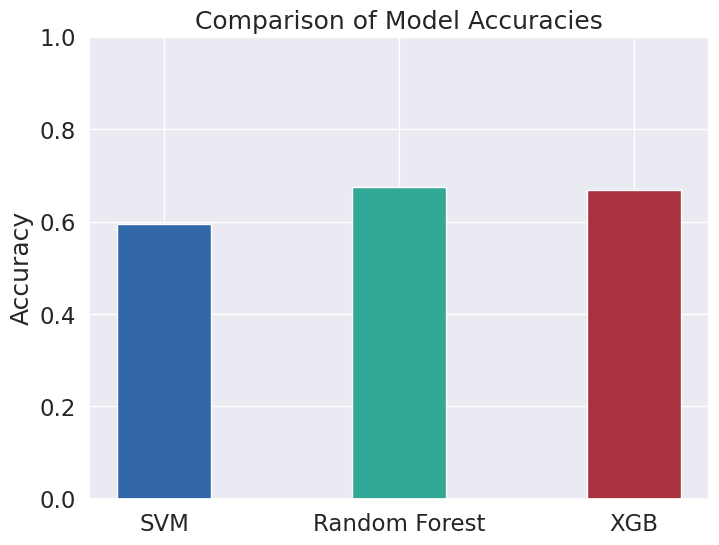

In [ ]:
# Names of models
models = ['SVM', 'Random Forest', 'XGB']

# Accuracy values
accuracies = [accuracy_svm, accuracy_rf, accuracy_xgb]

# Create bar graph
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['#3268a8', '#32a896', '#a8323e'], width=0.4)
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim([0, 1])
plt.show()


In [ ]:
# Classification reports
report_svm = classification_report(y_test, y_pred_svm)
report_rf = classification_report(y1_test, y_pred_rf)
report_xgb = classification_report(y1_test, y_pred_xgb)

print("Classification Report for SVM:\n", report_svm)
print("Classification Report for Random Forest:\n", report_rf)
print("Classification Report for XGB:\n", report_xgb)


Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.62      0.67      0.65       141
           1       0.52      0.49      0.50       161
           2       0.65      0.64      0.64       148

    accuracy                           0.60       450
   macro avg       0.60      0.60      0.60       450
weighted avg       0.59      0.60      0.59       450

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.66      0.79      0.72       223
           1       0.44      0.15      0.23       156
           2       0.70      0.83      0.76       305

    accuracy                           0.67       684
   macro avg       0.60      0.59      0.57       684
weighted avg       0.63      0.67      0.63       684

Classification Report for XGB:
               precision    recall  f1-score   support

           0       0.66      0.68      0.67       223
           1       0.36

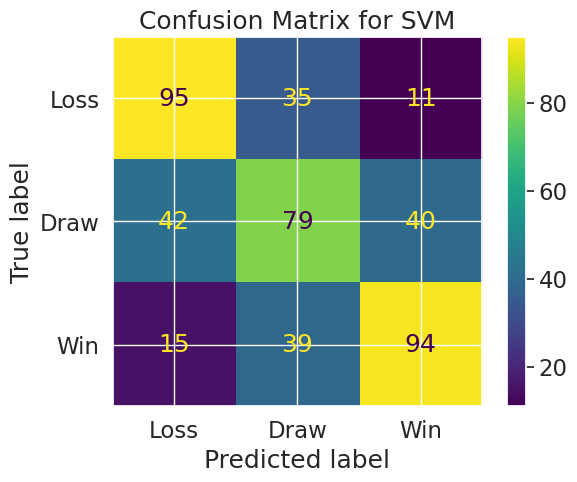

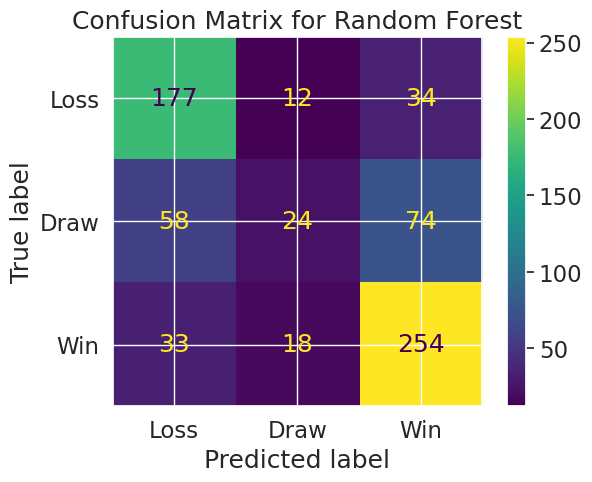

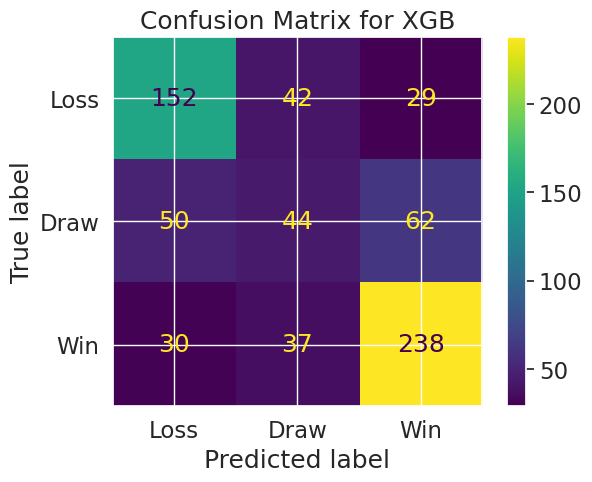

In [ ]:
# Confusion matrices using ConfusionMatrixDisplay
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_rf = confusion_matrix(y1_test, y_pred_rf)
cm_xgb = confusion_matrix(y1_test, y_pred_xgb)

# Labels for the classes
class_labels = ['Loss', 'Draw', 'Win']


# Plot Confusion Matrix for SVM
ConfusionMatrixDisplay(cm_svm, display_labels=class_labels).plot(values_format='d')
plt.title('Confusion Matrix for SVM')
plt.show()

# Plot Confusion Matrix for Random Forest
ConfusionMatrixDisplay(cm_rf, display_labels=class_labels).plot(values_format='d')
plt.title('Confusion Matrix for Random Forest')
plt.show()

# Plot Confusion Matrix for XGB
ConfusionMatrixDisplay(cm_xgb, display_labels=class_labels).plot(values_format='d')
plt.title('Confusion Matrix for XGB')
plt.show()

In [ ]:
# Optimize Parameters with Cross Validation for SVM model

param_grid = [
    {'C': [0.5, 1, 10, 100],
     'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
     'kernel': ['rbf']},
]

optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose = 0
)

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


In [ ]:
# Building Final SVM model
clf_sv = SVC(random_state = 42, C=10, gamma = 0.001, kernel = 'rbf')
clf_sv.fit(X_train_scaled, y_train)

SVC(C=10, gamma=0.001, random_state=42)

SVM Accuracy: 0.6088888888888889
Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.62      0.66      0.64       141
           1       0.52      0.50      0.51       161
           2       0.70      0.68      0.69       148

    accuracy                           0.61       450
   macro avg       0.61      0.61      0.61       450
weighted avg       0.61      0.61      0.61       450



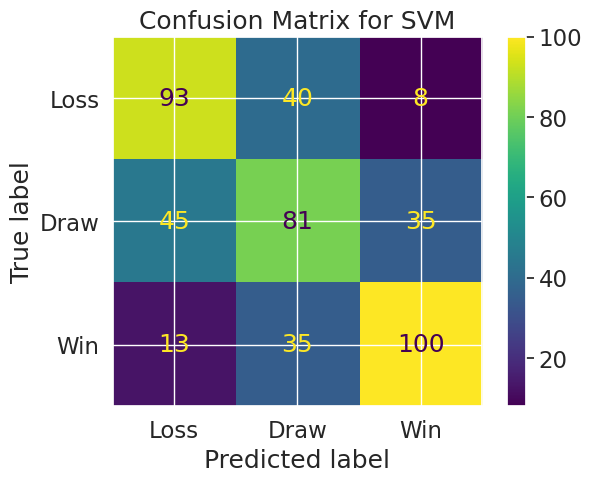

In [ ]:
# Predictions
y_pred_svm = clf_sv.predict(X_test_scaled)

# Accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy:", accuracy_svm)

# Classification reports
report_svm = classification_report(y_test, y_pred_svm)
print("Classification Report for SVM:\n", report_svm)

# Confusion matrices using ConfusionMatrixDisplay
cm_svm = confusion_matrix(y_test, y_pred_svm)


# Labels for the classes
class_labels = ['Loss', 'Draw', 'Win']


# Plot Confusion Matrix for SVM
ConfusionMatrixDisplay(cm_svm, display_labels=class_labels).plot(values_format='d')
plt.title('Confusion Matrix for SVM')
plt.show()


In [ ]:

# Define the RandomForestClassifier model
rf = RandomForestClassifier(random_state=1)

# Define the parameter distributions for RandomizedSearchCV
param_grids = {
    'n_estimators': np.arange(50, 201, 50),  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Instantiate the RandomizedSearchCV object
optimal_params = RandomizedSearchCV(estimator=rf, param_distributions=param_grids,
                                    n_iter=10, cv=5, scoring='accuracy',
                                    verbose=2, random_state=1, n_jobs=-1)

# Fit RandomizedSearchCV to the data
optimal_params.fit(X1_train, y1_train)

# Print the best parameters found by RandomizedSearchCV
print("Best parameters found: ", optimal_params.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found:  {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': True}


In [ ]:
#Building Final Random Forest Model
clf_rf = RandomForestClassifier(
    n_estimators=150,          # Number of trees
    min_samples_split=5,      # Minimum number of samples required to split an internal node
    min_samples_leaf=2,       # Minimum number of samples required to be at a leaf node
    max_depth= None,             # Maximum depth of the tree
    bootstrap=True,          # Whether bootstrap samples are used when building trees
    random_state=1            # Ensures a deterministic behavior for reproducibility
)

# Fit the model on your training data
clf_rf.fit(X1_train, y1_train)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=5,
                       n_estimators=150, random_state=1)

Rf Accuracy: 0.6754385964912281
Classification Report for Rf:
               precision    recall  f1-score   support

           0       0.69      0.78      0.73       223
           1       0.47      0.14      0.22       156
           2       0.69      0.87      0.77       305

    accuracy                           0.68       684
   macro avg       0.62      0.60      0.57       684
weighted avg       0.64      0.68      0.63       684



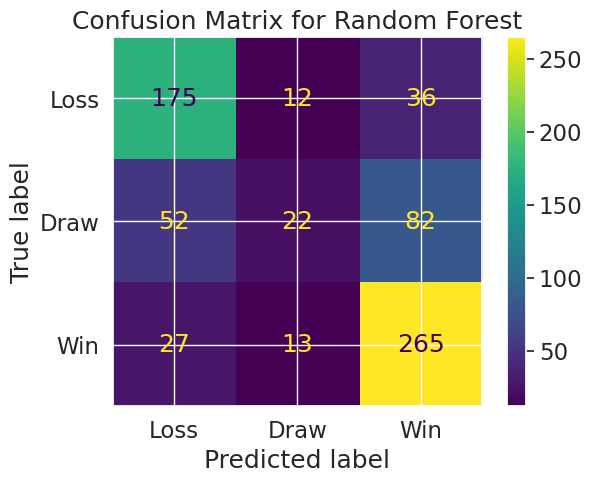

In [ ]:
# Predictions
y_pred_rf = clf_rf.predict(X1_test)

# Accuracy
accuracy_rf = accuracy_score(y1_test, y_pred_rf)
print("Rf Accuracy:", accuracy_rf)

# Classification reports
report_rf = classification_report(y1_test, y_pred_rf)
print("Classification Report for Rf:\n", report_rf)

# Confusion matrices using ConfusionMatrixDisplay
cm_rf = confusion_matrix(y1_test, y_pred_rf)


# Labels for the classes
class_labels = ['Loss', 'Draw', 'Win']


# Plot Confusion Matrix for SVM
ConfusionMatrixDisplay(cm_rf, display_labels=class_labels).plot(values_format='d')
plt.title('Confusion Matrix for Random Forest')
plt.show()


In [ ]:
# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5],  # Reduced complexity
    'learning_rate': [0.1, 0.05],  # Common starting values
    'gamma': [0 ,0.1],  # Reduced range to avoid extreme values
    'reg_lambda': [0, 1]  # Common regularization values
}

# Set up the GridSearchCV object for multi-class classification
optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='multi:softmax', num_class=3, seed=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2
)

# Fit GridSearchCV to the training data
optimal_params.fit(X1_train, y1_train)

# Print the best parameters found
print("Best parameters found: ", optimal_params.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=0; total time=   0.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=0; total time=   0.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=0; total time=   0.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=0; total time=   0.2s
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=0; total time=   0.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=1; total time=   0.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=1; total time=   0.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=1; total time=   0.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=1; total time=   0.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=1; total time=   0.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=0; total time=   0.2s
[CV] END gamma=0, learnin

In [ ]:
# Building Final Model
clf_xgb = xgb.XGBClassifier(objective='multi:softmax', missing = 0, seed = 42,
                            gamma = 0.1,
                            learning_rate = 0.1,
                            max_depth = 4,
                            reg_lambda = 0,
                            )
clf_xgb.fit(X1_train, y1_train, eval_set=[(X1_test, y1_test)],verbose=True)


[0]	validation_0-mlogloss:1.05262
[1]	validation_0-mlogloss:1.01447
[2]	validation_0-mlogloss:0.98243
[3]	validation_0-mlogloss:0.95398
[4]	validation_0-mlogloss:0.92968
[5]	validation_0-mlogloss:0.90952
[6]	validation_0-mlogloss:0.89172
[7]	validation_0-mlogloss:0.87434
[8]	validation_0-mlogloss:0.86057
[9]	validation_0-mlogloss:0.84711
[10]	validation_0-mlogloss:0.83484
[11]	validation_0-mlogloss:0.82330
[12]	validation_0-mlogloss:0.81295
[13]	validation_0-mlogloss:0.80469
[14]	validation_0-mlogloss:0.79665
[15]	validation_0-mlogloss:0.79011
[16]	validation_0-mlogloss:0.78480
[17]	validation_0-mlogloss:0.77992
[18]	validation_0-mlogloss:0.77537
[19]	validation_0-mlogloss:0.77232
[20]	validation_0-mlogloss:0.76834
[21]	validation_0-mlogloss:0.76498
[22]	validation_0-mlogloss:0.76136
[23]	validation_0-mlogloss:0.75952
[24]	validation_0-mlogloss:0.75735
[25]	validation_0-mlogloss:0.75501
[26]	validation_0-mlogloss:0.75395
[27]	validation_0-mlogloss:0.75209
[28]	validation_0-mlogloss:0.7

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=0, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

Xgb Accuracy: 0.6681286549707602
Classification Report for Xgb:
               precision    recall  f1-score   support

           0       0.69      0.74      0.71       223
           1       0.43      0.26      0.33       156
           2       0.72      0.82      0.77       305

    accuracy                           0.67       684
   macro avg       0.61      0.61      0.60       684
weighted avg       0.64      0.67      0.65       684



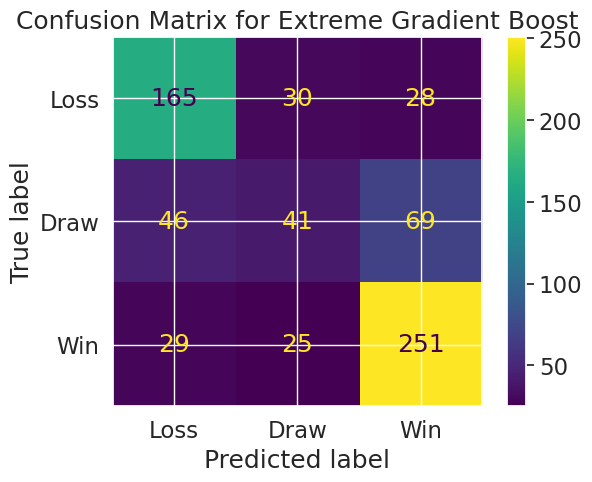

In [ ]:
# Predictions
y_pred_xgb = clf_xgb.predict(X1_test)

# Accuracy
accuracy_xgb = accuracy_score(y1_test, y_pred_xgb)
print("Xgb Accuracy:", accuracy_xgb)

# Classification reports
report_xgb = classification_report(y1_test, y_pred_xgb)
print("Classification Report for Xgb:\n", report_xgb)

# Confusion matrices using ConfusionMatrixDisplay
cm_xgb = confusion_matrix(y1_test, y_pred_xgb)


# Labels for the classes
class_labels = ['Loss', 'Draw', 'Win']


# Plot Confusion Matrix for SVM
ConfusionMatrixDisplay(cm_xgb, display_labels=class_labels).plot(values_format='d')
plt.title('Confusion Matrix for Extreme Gradient Boost')
plt.show()

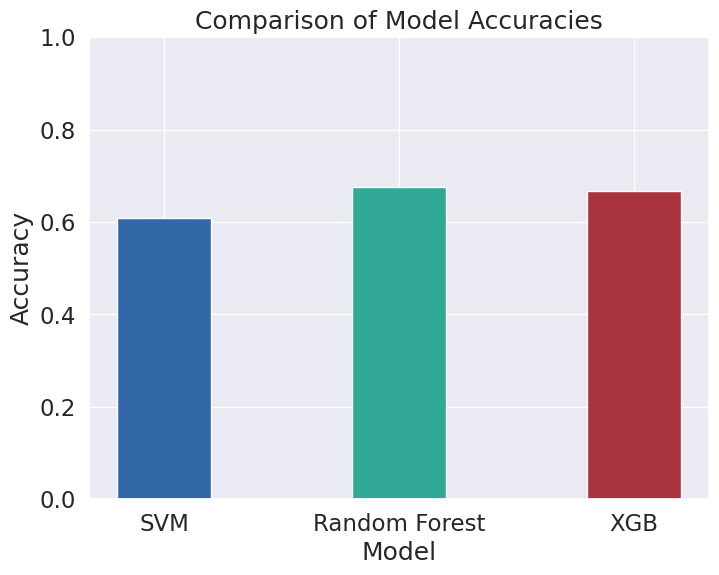

In [ ]:
# Names of models
models = ['SVM', 'Random Forest', 'XGB']

# Accuracy values
accuracies = [accuracy_svm, accuracy_rf, accuracy_xgb]

# Create bar graph
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['#3268a8', '#32a896', '#a8323e'], width=0.4)  # Adjust width for thinner bars
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim([0, 1])  # Set y-axis limit to show accuracy from 0 to 1 (or 0% to 100%)
plt.show()